# Hidden Markov Model with timeseries data

This notebook was inspired by the following resources:
- https://www.tutorialspoint.com/artificial_intelligence_with_python/artificial_intelligence_with_python_analyzing_time_series_data.htm

- https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4


# A. Set up

### A.1 Import libraries and variables

In [1]:
import numpy as np
import pandas as pd

from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

### A.2 Load dataset

Music dataset by Marsyas
- collection of 1000 audio tracks each 30 seconds long. There are 10 genres represented, each containing 100 tracks. 
- All the tracks are 22050Hz Mono 16-bit audio files in .au format. In our tutorial, we will use all provided genres (blues, classical, jazz, country, pop, rock, metal, disco, hip-hop, reggae). 
- For music genre classification, we will be easier for us to use WAV files, because they can be easily read by the scipy library. We would, therefore, have to convert our AU files to WAV format.


In [2]:
input_folder = '../examples/music_genres/'

## B. Data exploration

### B.1 Extracting MFCC and Filter bank features from a song

- Mel Frequency Cepstral Coefficients (MFCC): takes the power spectrum of a signal and then uses a combination of filter banks and discrete cosine transform to extract features.



In [3]:
test_file = "../examples/music_genres/blues/blues.00000.wav"

sampling_freq, audio = wavfile.read(test_file)
mfcc_features = mfcc(audio, sampling_freq , nfft=1024)
filterbank_features = logfbank(audio, sampling_freq, nfft=1024)

print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 2994
Length of each feature = 13

Filter bank:
Number of windows = 2994
Length of each feature = 26


### B.2 Visualizing features for a song from each genre

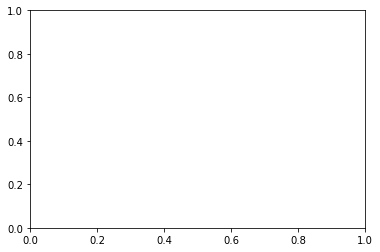

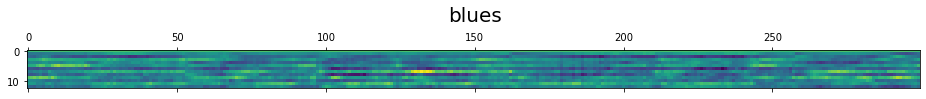

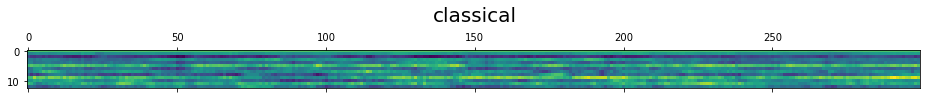

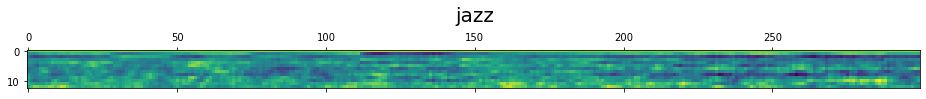

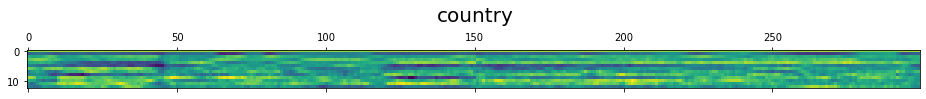

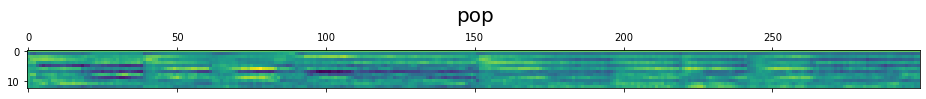

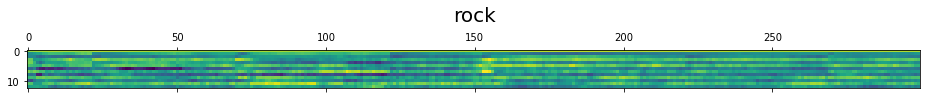

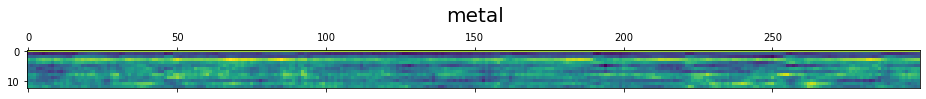

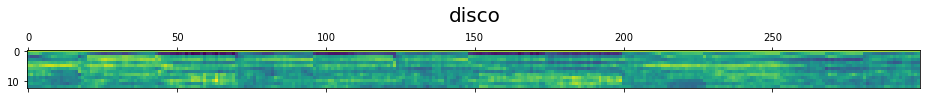

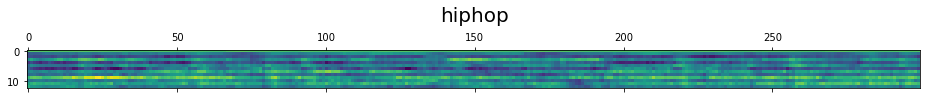

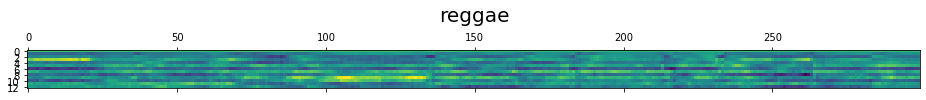

In [8]:
import glob
import os.path as path
import matplotlib.pyplot as plt

genre_list = ["blues", "classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]

for idx, genre in enumerate(genre_list): 

   example_data_path = "../examples/music_genres/" + genre

   # glob = allows you to find files recursively 
   file_paths = glob.glob(path.join(example_data_path, "*.wav"))
   
   # read first file
   sampling_freq, audio = wavfile.read(file_paths[0])

   # nfft = frame length size
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   
   plt.yscale("linear")

   # plot the first 300
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment="center", fontsize=20)

## C. Feature extraction
- Extracting MFCC and Filter bank features from a song
- Mel Frequency Cepstral Coefficients (MFCC): takes the power spectrum of a signal and then uses a combination of filter banks and discrete cosine transform to extract features.


In [9]:
def extract_features(input_folder: str):
    """
    Extract MFCC and Filter bank features from a song in .wav form

    Inputs:
    - input_folder: name of input folder containing the songs

    Outputs:
    - 
    """

    # get train_df and test_df
    df = pd.DataFrame(columns=["file_name", "label", "mfcc", "filter_bank"])

    # parse through input directory
    for folder in os.listdir(input_folder):
        # get full path of folder
        full_path = os.path.join(input_folder, folder)
        
        # if not folder, ignore
        if not os.path.isdir(full_path):
            continue

        label = full_path[full_path.rfind('/') + 1:]
        
        # for each file inside genre folder
        for file_name in os.listdir(full_path):
            if not file_name.endswith('.wav'):
                continue
                
            file_path = os.path.join(full_path, file_name)

            # extract features
            sampling_freq, audio = wavfile.read(file_path)
            mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
            filterbank_features = logfbank(audio, sampling_freq, nfft=1024)

            df = df.append({"file_name": file_path, "label": label, "mfcc":mfcc_features, "filter_bank":filterbank_features}, ignore_index= True)
    
    return df

In [10]:
# Extract MFCC and Filter bank features for songs inside 'input_folder'
df = extract_features(input_folder)
df.head()

,file_name,label,mfcc,filter_bank
0,../examples/music_genres/blues/blues.00000.wav,blues,"[[17.108868284156756, -10.079314678783394, -13...","[[11.239401763575179, 10.481149767965961, 11.7..."
1,../examples/music_genres/blues/blues.00001.wav,blues,"[[14.70106580713718, 14.218511830802544, -12.7...","[[10.685073155161634, 12.080311613118921, 12.3..."
2,../examples/music_genres/blues/blues.00002.wav,blues,"[[20.597252199459458, 2.3036196783174265, -28....","[[14.148386404946956, 13.843078165266373, 15.7..."
3,../examples/music_genres/blues/blues.00003.wav,blues,"[[17.549029718152916, 17.671835444610345, -10....","[[15.700609273994802, 15.468431584813697, 13.4..."
4,../examples/music_genres/blues/blues.00004.wav,blues,"[[15.94300809339147, 6.718133947129774, -17.27...","[[6.776209923990333, 10.411872539550098, 12.51..."


## D. Data Splits

In [12]:
from sklearn.model_selection import train_test_split

def run_data_split(df: pd.DataFrame, label_col = "label"):
    """
    Get train and test data frames using stratified splitting

    Inputs:
    - df: dataframe of all songs and corresponding features 

    Outputs: 
    - train_df: dataframe of songs and corresponding features in train split
    - test_df: dataframe of songs and corresponding features in test split
    - y_train: labels (song genre) of data points in train_df
    - y_test: labels (song genre) of data points in test_df
    """

    idx_train, idx_test, y_train, y_test = train_test_split(df.index, df[label_col].values, test_size=0.33, random_state=109, stratify=df[label_col].values)

    # get train and test df
    train_df = df.iloc[idx_train]
    test_df = df.iloc[idx_test]

    return train_df, test_df, y_train, y_test

In [13]:
train_df, test_df, y_train, y_test = run_data_split(df)

print("Train= x: " , train_df.shape, " , y: " , y_train.shape)
print("Test= x: " , test_df.shape, " , y: " , y_test.shape)

Train= x:  (670, 4)  , y:  (670,)
Test= x:  (330, 4)  , y:  (330,)


## E. Hidden Markov model to predict song genre


Hidden markov model overview:

https://medium.com/@jonathan_hui/machine-learning-hidden-markov-model-hmm-31660d217a61
- internal states are difficult to observe. therefore we can determine internal states from observable external factors 
- markov process: stochastic (randomly determined) process in which future state solely depends on current state only. helps solve complex ML and RL problems 
- probability of transition from one state to another can be packed into a transition matrix (ie. Markov matrix) 
- only final state is observable. and internal states is hidden. 
- major assumptions of HMM = next state and current observation is only dependent on current state

- HMM models process with markov process.
1. includes initial state distribution pi (probability distribution of initial state) 
2. transition probability A from one state to another 
3. likelihood B (emission probabilities, probability of observation given specific internal state) of observation given a hidden state 

HMM and time series classification:
- Develop a hidden markov model for each class (ie. genre) --> to understand the distribution of the samples that belong to the class
- Given unseen data, calculate the log likelihood of it belonging to each class --> the model that yields the highest likelihood is chosen to be the predicted model
- HMM are good for capturing temporal relationships = good for time series data analysis

- using hmmlearn library: https://github.com/hmmlearn/hmmlearn


### E.1 Define Hidden Markov Model 

Types of HMMs: 
- GaussianHMM: HMM with gaussian emissions
    - continuous observations at each state, observation is a normal gaussian distribution

- GMMHMM: HMM with gaussian mixture emissions
    - mixture of continuous observations at each state, observation is a mixture of gaussian distributions
    - GMM -> able to self organize to fit a dataset
    - if the feature vectors associated with a state is strongly non-gaussian, you should use gaussian mixture emissions
    - This can model any distribution well

- MultinomialHMM: HMM with multinomial (discrete) emissions         
    - discrete observations at each state


Parameters tuning for HMM:

https://medium.com/analytics-vidhya/hidden-markov-model-a-statespace-probabilistic-forecasting-approach-in-quantitative-finance-df308e259856

- n_components = number of hidden states
    - can do grid search to find optimal number of hidden states

- covariance_type = options to constrain the covariance of different classes estimated
    - covariance: joint probability of 2 random variables. large covariance = variables are highly correlated to each other 
    - eg. spherical, diagonal, tied or full covariance
    - use gridsearch to determine optimal type of covariance




In [14]:
from hmmlearn import hmm

def getHmmModel(model_name:str, n_components: int, cov_type: str, n_iter: int):
    """
    Gets HMM model with correct inputs
    """

    if model_name == "GaussianHMM":
        return hmm.GaussianHMM(n_components=n_components,covariance_type=cov_type,n_iter=n_iter)
    
    elif model_name == "GMMHMM":
        return hmm.GMMHMM(n_components=self.n_components,covariance_type=cov_type,n_iter=n_iter)
    
    elif model_name == "MultinomialHMM":
        return hmm.MultinomialHMM(n_components=n_components,covariance_type=cov_type,n_iter=n_iter)

    else:
        return "Invalid name"

### E.2 Train hmm based on mfcc features
- Traing 1 HMM model for each class (ie. genre of music)
- store models trained for each class in the HMMTrainer
- if you want to do multivariate, they need to be of same dimensions (ie. same number of time steps)

In [15]:
def format_vector(features: np.array):
    """
    Format the vector for HMM
    - HMM = takes values from 1 class = can concatenate samples 
    - num samples = timeseries steps
    format = (num_samples, num_features)
    """
    x = []
    for i in range(len(features)):
        if len(x) == 0:
            x = features[i]

        else:
            x = np.append(x, features[i], axis=0)

    return x

In [ ]:
import itertools
import os
import pickle

def save_hmm_models(feature_col: str, n_features: int, label_col = "label", model_name = "GaussianHMM", n_components = 10, cov_type = "diag", n_iter = 1000, path = "../examples"):
    """
    Train a HMM model for every genre of songs found in train data set and save them as a dictionary
    
    Inputs:
    - feature_col: column name of feature to train HMM model (eg. MFCC, filter_bank)
    - n_features: number of features for type of feature chosen
    - label_col: name of label col, defaults to "label"
    - model_name: name of HMM model to use, defaults to "GaussianHMM"
    - n_components: number of hidden states for HMM model, defaults to 10
    - cov_type: covariance type of HMM model, defaults to "diag"
    - n_iter: max number of iterations to perform, defaults to 1000
    - n_features_mfcc: , defaults to 13
    - path: path to save hmm dict that contains trained models, defaults to "../examples"

    Outputs:
    - hmm_models saved at path (ie. trained HMM model for each label type)
    """
    hmm_models = dict()

    # Train HMM for each genre from train df
    genres = train_df[label_col].unique()

    for genre in genres:
        print(genre)
        genre_df = train_df.loc[train_df[label_col] == genre]

        model = getHmmModel(model_name, n_components, cov_type, n_iter)
        model.n_features = n_features

        # format x_train vector
            # (number of samples (in time series), number of features)
        x_train = format_vector(genre_df[feature_col].values)

        # ignore floating point errors
        np.seterr(all='ignore')
        model.fit(x_train)

        hmm_models[genre] = model

    # save hmm models dict
    full_path = path. + "/hmm_models.pickle"
    with open(full_path, 'wb') as handle:
        pickle.dump(hmm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
num_mfcc_features = mfcc_features.shape[1]

# Train HMM models based on MFCC
save_hmm_models("MFCC", num_mfcc_features)

blues
rock
jazz
pop
country
classical
hiphop
metal
disco
reggae


### E.3 Predict most likely genre using trained HMM models

In [32]:
import pickle

def predict_genre(x_test: np.array, hmm_models:dict):
    """
    Predict likely genre given HMM models fitted on different genres of music and x_test

    Inputs:
    - x_test: test data to predict (number of samples, number of features)
    - hmm_models: dictionary of HMM models per genre

    Outputs:
    - 2D array [label predicted (ie. genre of music), prediction probabilities]
    """
    
    # Predict likely genre
    genres = test_df["label"].unique()

    max_score = -9999999999999999999
    pred_label = None
    pred_probabilities = []

    # evaluate HMM per genre to predict likely genre
    for genre in genres:
        model = hmm_models[genre]
        score = model.score(x_test)
        pred_probabilities.append(score)

        if score > max_score:
            max_score = score
            pred_label = genre
    

    return np.asarray([pred_label, pred_probabilities])

In [33]:
# load HMM model dict
with open('../examples/hmm_models.pickle', 'rb') as handle:
    hmm_models = pickle.load(handle)

# Get predictions for test_df
test_df["y_pred"] = test_df.apply(lambda row: predict_genre(row["mfcc"], hmm_models), axis = 1)

test_df.head()

,file_name,label,mfcc,filter_bank,y_pred
162,../examples/music_genres/classical/classical.0...,classical,"[[17.923927405804715, 3.6021274734181166, -13....","[[14.033507686363167, 13.274087301220257, 14.9...","[classical, [-135762.5839096826, -149630.39994..."
329,../examples/music_genres/disco/disco.00029.wav,disco,"[[20.23796011528799, -11.706846141624524, -6.8...","[[13.206004211394301, 14.752554688409836, 15.7...","[pop, [-155170.1743828405, -135924.87737487003..."
723,../examples/music_genres/pop/pop.00023.wav,pop,"[[22.666647299101363, -32.47054486707432, 18.5...","[[14.381441655546832, 14.651874106266405, 14.4...","[pop, [-162246.62674354934, -144268.6689444480..."
687,../examples/music_genres/metal/metal.00087.wav,metal,"[[23.806662536576148, -25.589186276636227, -2....","[[17.00207076197643, 16.939645049278926, 14.94...","[metal, [-157721.05634459673, -137435.88683781..."
779,../examples/music_genres/pop/pop.00079.wav,pop,"[[17.546396572033206, -11.607688479145127, 0.4...","[[13.48546782646081, 13.207561675932459, 12.19...","[country, [-146147.38028149522, -145037.349210..."


### E.4 Evaluate predictions
https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

- classification report:
    - Precision (tp / (tp + fp) ) measures the ability of a classifier to identify only the correct instances for each class.
    - Recall (tp / (tp + fn): ability of a classifier to find all correct instances per class.
    - F1 score: weighted harmonic mean of precision and recall normalized between 0 and 1. F score of 1 indicates a perfect balance as precision and the recall are inversely related. A high F1 score is useful where both high recall and precision is important.
    - Support: number of actual occurrences of the class in the test data set. Imbalanced support in the training data may indicate the need for stratified sampling or rebalancing.

- Confusion matrix:
    - shows the combination of the actual and predicted classes. 
    - good measure of whether models can account for the overlap in class properties and understand which classes are most easily confused.
    - row: represents the instances in a predicted class,
    - column: represents the instances in an actual class. 

- Class Prediction Error:
    - useful extension of the confusion matrix and visualizes the misclassified classes as a stacked bar. Each bar is a composite measure of predicted classes
    
- Cohen’s Kappa:
    - best metrics for evaluating multi-class classifiers on imbalanced datasets.
    - traditional metrics from the classification report are biased towards the majority class and assumes an identical distribution of the actual and predicted classes. 
    - Cohen’s Kappa Statistic measures the proximity of the predicted classes to the actual classes when compared to a random classification. 
        - The output is normalized between 0 and 1 the metrics for each classifier, therefore can be directly compared across the classification task. 
    - Generally closer the score is to one, better the classifier.
    
- Cross-entropy:
    - measures the extent to which the predicted probabilities match the given data
        - useful for probabilistic classifiers (eg. Naïve Bayes) 
    - It is a more generic form of the logarithmic loss function, which was derived from neural network architecture, and is used to quantify the cost of inaccurate predictions. 
    - The classifier with the lowest log loss is preferred.

- Mathews Correlation Coefficient (MCC):
    - A coefficient of +1 represents a perfect prediction, 0 is similar to a random prediction and −1 indicates an inverse prediction.
    





In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, normalize, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    obtained from: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [47]:
# Obtain predictions and true labels for test dataframe
y_pred = test_df["y_pred"].values
y_pred = np.asarray([row[0] for row in y_pred])
y_pred_probabilities = np.asarray([row[1] for row in y_pred])
y_true = test_df["label"].values

print(y_pred.shape)
print(y_pred_probabilities.shape)

(330,)
(330, 10)


In [48]:
from sklearn.metrics import classification_report

# Print classification report to view performance across label types
target_names = test_df["label"].unique()
print(classification_report(y_true, y_pred, target_names=target_names))


precision    recall  f1-score   support

   classical       0.72      0.64      0.68        33
       disco       0.94      0.88      0.91        33
         pop       0.56      0.45      0.50        33
       metal       0.51      0.67      0.58        33
     country       0.57      0.61      0.59        33
      hiphop       0.81      0.64      0.71        33
        jazz       0.76      0.85      0.80        33
       blues       0.60      0.85      0.70        33
        rock       0.65      0.61      0.62        33
      reggae       0.62      0.45      0.53        33

    accuracy                           0.66       330
   macro avg       0.67      0.66      0.66       330
weighted avg       0.67      0.66      0.66       330



<Figure size 432x288 with 0 Axes>

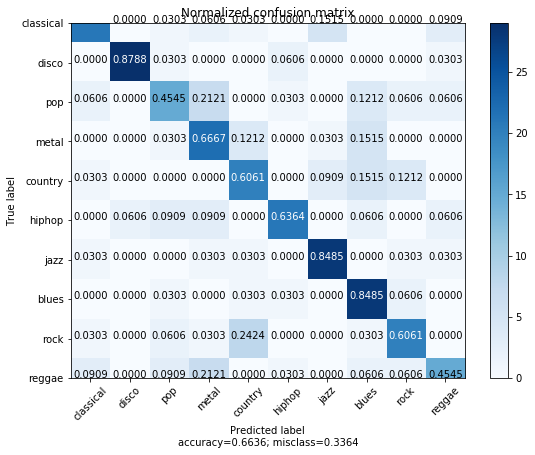

In [49]:
from sklearn.metrics import confusion_matrix

# Print confusion matrix to view performance across label types
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

classes = test_df["label"].unique()
plt.figure()
plot_confusion_matrix(cm, target_names=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

In [50]:
from sklearn.metrics import log_loss

# Evaluate cross-entropy loss on prediction
    # lower the log loss = better
print(log_loss(y_true, y_pred_probabilities))

2.3025850929940463
